In [1]:
import pandas as pd
import torch
import torchvision
import torchvision.models

from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

from PIL import ImageFile

In [2]:
# 1.transforms.Compose()对图像进行各种转换操作，并用函数compose()将这些转换操作组合起来；
# 2.transforms.RandomResizedCrop(224)将给定图像随机裁剪为不同的大小和宽高比，然后缩放所裁剪得到的图像为指定的大小；
# （即先随机采集，然后对裁剪得到的图像缩放为同一大小）
# 3.transforms.RandomHorizontalFlip()以给定的概率随机水平旋转给定的PIL的图像，默认概率为0.5；
# 4.transforms.ToTensor()将给定图像转为Tensor形式
# 5.transforms.Normalize()对数据进行归一化处理
# 6.transforms.Resize([h, w])指定图片的高宽大小

data_transform = {
    "train": transforms.Compose([transforms.Resize((224, 224)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ]),
    "val": transforms.Compose([transforms.Resize((224, 224)),  # cannot 224, must (224, 224)
                               transforms.ToTensor(),])}

In [3]:
# 训练集
train_data = torchvision.datasets.ImageFolder(root = "./data/train", transform = data_transform["train"])
Train_Data = DataLoader(dataset= train_data , batch_size= 64 , shuffle= True , num_workers=0)
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 224, 224])
torch.Size([64])
torch.Size([3, 224, 224])


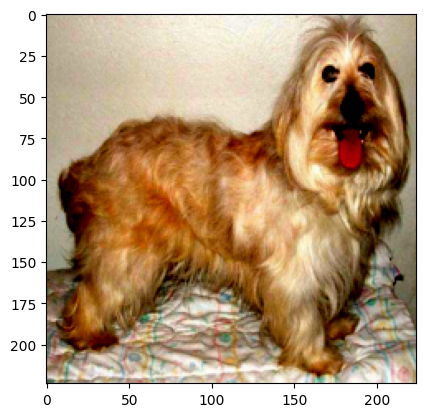

In [4]:
import matplotlib.pyplot as plt
import numpy as np

for i,data in enumerate(Train_Data):
    print(data[0].shape)
    print(data[1].shape)
    print(data[0][0].shape)
    img = data[0][0]
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0)) # C*H*W -> H*W*C
    plt.imshow(img)
    plt.show()
    break

In [5]:
print(train_data.class_to_idx) #按顺序为这些类别定义索引为0,1...

{'cat': 0, 'dog': 1}


In [6]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()

        self.layer1=nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1), #(224-3+2)/1+1=224   224*224*64
            nn.BatchNorm2d(64),
            #inplace-选择是否进行覆盖运算
            #意思是是否将计算得到的值覆盖之前的值，比如
            nn.ReLU(inplace=True),
            #意思就是对从上层网络Conv2d中传递下来的tensor直接进行修改，
            #这样能够节省运算内存，不用多存储其他变量

            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), #(224-3+2)/1+1=224   224*224*64
            #Batch Normalization强行将数据拉回到均值为0，方差为1的正太分布上，
            # 一方面使得数据分布一致，另一方面避免梯度消失。
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2,stride=2)   #(224-2)/2+1=112         112*112*64
        )


        self.layer2=nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),  #(112-3+2)/1+1=112  112*112*128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), #(112-3+2)/1+1=112   112*112*128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2,2)    #(112-2)/2+1=56     56*56*128
        )

        self.layer3=nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),  #(56-3+2)/1+1=56   56*56*256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),


            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1),  #(56-3+2)/1+1=56   56*56*256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1),  #(56-3+2)/1+1=56   56*56*256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2,2)     #(56-2)/2+1=28      28*28*256
        )

        self.layer4=nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=1),  #(28-3+2)/1+1=28   28*28*512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1),   #(28-3+2)/1+1=28   28*28*512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1),   #(28-3+2)/1+1=28   28*28*512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2,2)    #(28-2)/2+1=14     14*14*512
        )

        self.layer5=nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1),   #(14-3+2)/1+1=14   14*14*512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1),  #(14-3+2)/1+1=14   14*14*512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1),  #(14-3+2)/1+1=14   14*14*512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2,2)   #(14-2)/2+1=7      7*7*512
        )


        self.conv=nn.Sequential(
            self.layer1,
            self.layer2,
            self.layer3,
            self.layer4,
            self.layer5
        )

        self.fc=nn.Sequential(
            #y=xA^T+b  x是输入,A是权值,b是偏执,y是输出
            #nn.Liner(in_features,out_features,bias)
            #in_features:输入x的列数  输入数据:[batchsize,in_features]
            #out_freatures:线性变换后输出的y的列数,输出数据的大小是:[batchsize,out_features]
            #bias: bool  默认为True
            #线性变换不改变输入矩阵x的行数,仅改变列数
            nn.Linear(in_features=512*7*7, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(in_features=4096, out_features=2),
            ## nn.softmax(dim=1)
        )


    def forward(self,x):
        x=self.conv(x) # 卷积层
        x=x.view(x.size(0),-1) # 展平
        x=self.fc(x)
        return x



In [8]:
model = VGG16()
print(model)

VGG16(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

### ①交叉熵损失函数会自动对输入模型的预测值进行softmax。因此在多分类问题中，如果使用nn.CrossEntropyLoss()，则预测模型的输出层无需添加softmax层。

### ②nn.CrossEntropyLoss()=nn.LogSoftmax()+nn.NLLLoss().

In [59]:
from torch.autograd import Variable
learning = 0.001 # 学习率
vgg16 = VGG16()
optimizer = torch.optim.Adam(vgg16.parameters(), lr = learning) # 优化器
loss = nn.CrossEntropyLoss() # 损失函数，交叉熵损失


In [63]:
## ----------
##  Training
## ----------
## 进行多个epoch的训练
for epoch in range(3):                               ## epoch:50
    vgg16.train()
    train_loss = 0
    train_num = 0.0
    train_accuracy = 0.0
    train_bar = tqdm(Train_Data) # 进度条描述
    for i, (imgs, label) in enumerate(train_bar):                      ## imgs:(64, 3, 224, 224)     label(64)
        img = Variable(imgs)                                      ## 将tensor变成Variable放入计算图中，tensor变成variable之后才能进行反向传播求梯度
        outputs = vgg16(img) # 输出预测值
        loss1  = loss(outputs, label) # 损失
        optimizer.zero_grad() # 将梯度初始化为零
        loss1.backward() # 反向传播
        optimizer.step() # 优化，更新参数的值

        outputs = torch.argmax(outputs, 1) # 返回索引值
        loss_total = abs(loss1.item())*img.size(0)
        train_loss += abs(loss1.item())*img.size(0) # 单次迭代误差之和
        accuracy = torch.sum(outputs == label) # 准确率
        train_accuracy = train_accuracy + accuracy # 单次迭代后的预测准确率
        train_num += img.size(0) # 总样本数目

        ## 打印训练过程中的日志
        ## item():取出单元素张量的元素值并返回该值，保持原元素类型不变
        print("[Epoch %d/%d] [Batch %d/%d] [accuracy: %f] [loss: %f]"% (epoch+1, 3, i+1, 9, accuracy/img.size(0), loss_total/img.size(0)))



    print("epoch:{} , train-Loss:{} , train-accuracy:{}".format(epoch+1, train_loss/train_num , train_accuracy/train_num))


 11%|█         | 1/9 [00:45<06:05, 45.63s/it]

[Epoch 1/3] [Batch 1/9] [accuracy: 0.640625] [loss: 5.290479]


 22%|██▏       | 2/9 [01:12<04:02, 34.62s/it]

[Epoch 1/3] [Batch 2/9] [accuracy: 0.453125] [loss: 106.562393]


 33%|███▎      | 3/9 [01:39<03:06, 31.05s/it]

[Epoch 1/3] [Batch 3/9] [accuracy: 0.531250] [loss: 37.394630]


 44%|████▍     | 4/9 [02:06<02:26, 29.34s/it]

[Epoch 1/3] [Batch 4/9] [accuracy: 0.578125] [loss: 13.569786]


 56%|█████▌    | 5/9 [02:32<01:53, 28.43s/it]

[Epoch 1/3] [Batch 5/9] [accuracy: 0.515625] [loss: 4.719230]


 67%|██████▋   | 6/9 [02:59<01:23, 27.89s/it]

[Epoch 1/3] [Batch 6/9] [accuracy: 0.531250] [loss: 3.600811]


 78%|███████▊  | 7/9 [03:26<00:54, 27.39s/it]

[Epoch 1/3] [Batch 7/9] [accuracy: 0.437500] [loss: 2.924294]


 89%|████████▉ | 8/9 [03:52<00:27, 27.05s/it]

[Epoch 1/3] [Batch 8/9] [accuracy: 0.562500] [loss: 0.924016]


100%|██████████| 9/9 [03:55<00:00, 26.16s/it]


[Epoch 1/3] [Batch 9/9] [accuracy: 0.400000] [loss: 3.684739]
epoch：1 ， train-Loss：21.697300898959604 , train-accuracy：0.5299806594848633


 11%|█         | 1/9 [00:26<03:30, 26.34s/it]

[Epoch 2/3] [Batch 1/9] [accuracy: 0.453125] [loss: 1.984090]


 22%|██▏       | 2/9 [00:52<03:04, 26.36s/it]

[Epoch 2/3] [Batch 2/9] [accuracy: 0.578125] [loss: 1.317739]


 33%|███▎      | 3/9 [01:19<02:38, 26.39s/it]

[Epoch 2/3] [Batch 3/9] [accuracy: 0.468750] [loss: 0.898923]


 44%|████▍     | 4/9 [01:46<02:14, 26.93s/it]

[Epoch 2/3] [Batch 4/9] [accuracy: 0.468750] [loss: 0.972085]


 56%|█████▌    | 5/9 [02:14<01:48, 27.20s/it]

[Epoch 2/3] [Batch 5/9] [accuracy: 0.500000] [loss: 0.864170]


 67%|██████▋   | 6/9 [02:41<01:21, 27.13s/it]

[Epoch 2/3] [Batch 6/9] [accuracy: 0.515625] [loss: 0.776064]


 78%|███████▊  | 7/9 [03:07<00:53, 26.74s/it]

[Epoch 2/3] [Batch 7/9] [accuracy: 0.406250] [loss: 1.390457]


 89%|████████▉ | 8/9 [03:33<00:26, 26.55s/it]

[Epoch 2/3] [Batch 8/9] [accuracy: 0.515625] [loss: 0.792739]


100%|██████████| 9/9 [03:36<00:00, 24.10s/it]


[Epoch 2/3] [Batch 9/9] [accuracy: 0.200000] [loss: 1.590473]
epoch：2 ， train-Loss：1.129039433984738 , train-accuracy：0.4854932427406311


 11%|█         | 1/9 [00:26<03:33, 26.66s/it]

[Epoch 3/3] [Batch 1/9] [accuracy: 0.453125] [loss: 0.960933]


 22%|██▏       | 2/9 [00:53<03:09, 27.05s/it]

[Epoch 3/3] [Batch 2/9] [accuracy: 0.406250] [loss: 0.962601]


 33%|███▎      | 3/9 [01:20<02:40, 26.69s/it]

[Epoch 3/3] [Batch 3/9] [accuracy: 0.625000] [loss: 0.773054]


 44%|████▍     | 4/9 [01:46<02:13, 26.62s/it]

[Epoch 3/3] [Batch 4/9] [accuracy: 0.468750] [loss: 1.351923]


 56%|█████▌    | 5/9 [02:12<01:45, 26.34s/it]

[Epoch 3/3] [Batch 5/9] [accuracy: 0.500000] [loss: 0.857501]


 67%|██████▋   | 6/9 [02:39<01:19, 26.41s/it]

[Epoch 3/3] [Batch 6/9] [accuracy: 0.390625] [loss: 1.545687]


 78%|███████▊  | 7/9 [03:05<00:52, 26.45s/it]

[Epoch 3/3] [Batch 7/9] [accuracy: 0.625000] [loss: 0.726286]


 89%|████████▉ | 8/9 [03:32<00:26, 26.47s/it]

[Epoch 3/3] [Batch 8/9] [accuracy: 0.468750] [loss: 1.501942]


100%|██████████| 9/9 [03:35<00:00, 23.92s/it]

[Epoch 3/3] [Batch 9/9] [accuracy: 0.400000] [loss: 1.125536]
epoch：3 ， train-Loss：1.0853830910282394 , train-accuracy：0.4912959337234497


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


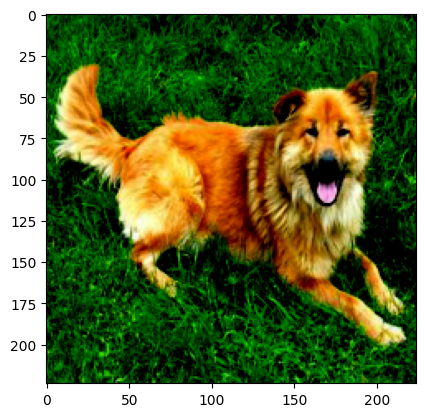

tensor([[-0.0450,  0.1046]], grad_fn=<AddmmBackward0>)
1
结果为 dog


In [72]:
import torch
from PIL import Image
from torch import nn
from torchvision.transforms import transforms

image_path = "./data/test/4.JPG"
trans = transforms.Compose([transforms.Resize((224 , 224)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                           ])
image = Image.open(image_path)
image = image.convert("RGB")
image = trans(image)
print(image.shape)

img = image.numpy()
img = np.transpose(img, (1, 2, 0)) # C*H*W -> H*W*C
plt.imshow(img)
plt.show()

image = torch.unsqueeze(image, dim=0)
classes = ["cat" , "dog"] # 分类

vgg16.eval() # 屏蔽dropout层
outputs = vgg16(image)

print(outputs)
ans = (outputs.argmax(1)).item()
print(ans)
print('结果为',classes[ans])
